## Federated Machine Learning vs. Non Federated

The goal of this notebook is to compare PySyft Federated Learning against normal PyTorch Learning. We will try to address the following questions:

 * Is there any difference in terms of performance between both approches?
 * How is the dataset federated between workers?
 * How is the learning process executed in federated learning? 
 
*Important note: This notebook follows the common implementation of pysyft toy examples. Thus, we simulate some core functionalities using the classes DataLoader, FederatedDataLoader and Virtual Workers*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics as m 
import seaborn as sns
np.random.seed(4567)

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler


# we create some dicts to store losses
torch_loss_stats = {
    'torch loss train': [],
    'torch loss val': []
}

syft_loss_stats = {
    'syft loss train': [],
    'syft loss val': []
}

### Step.1. Dataset creation and preparation

We will generate a simple regression dataset y = a*x + b. with some gaussian noise. 

#### 1.1. Generate synthetic dataset

In [2]:
n_samples = 500
x_ = np.sort(np.random.random(size=n_samples))

# create the true signal to be learned
coeff_ = 2
bias_ = 1
y_ = coeff_*x_ + bias_

# y = a*x + b with noise
wh_noise = np.random.normal(scale=10, size=n_samples)
y = y_  * wh_noise

#### 1.2. Split the dataset in training and validation

We will use 25% data points for validation and the rest for training.

In [3]:
val_pts = int(len(y)*0.25)

sample_idx = np.random.choice(range(0, len(y)), len(y))
training_idx, val_idx = sample_idx[val_pts:], sample_idx[:val_pts]

x_val, x = x_[val_idx], x_[training_idx]
y_val, y = y[val_idx], y[training_idx]

In [4]:
len(x_val), len(x)

(125, 375)

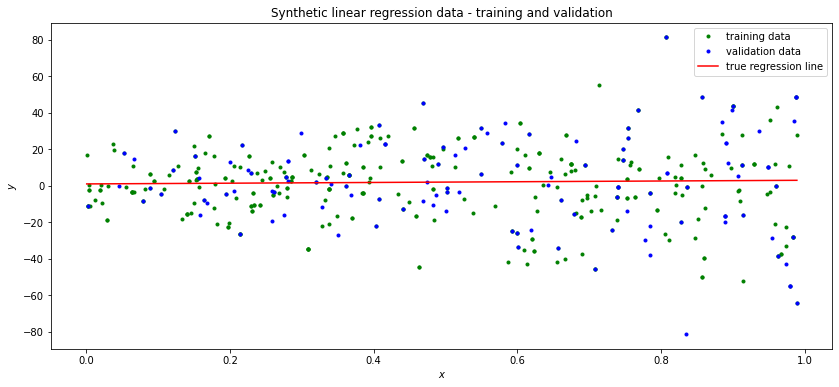

In [5]:
plt.figure(figsize=(14,6))
plt.title("Synthetic linear regression data - training and validation")
train, = plt.plot(x, y, '.', color='green', label='training data') 
val, = plt.plot(x_val, y_val, '.', color='blue', label='validation data') 
true_line, = plt.plot(x_, y_, color='red', label='true regression line') 
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.legend(handles=[train, val, true_line])
plt.show()

We have a syntethic regression dataset with gaussian multiplicative noise. 125 data points are for validation and 375 for training.

#### 1.3. Create PyTorch Dataset 

We transform the numpy vectors into tensors.

In [6]:
x_t, y_t = torch.from_numpy(x.reshape(-1,1).astype('float32')), torch.from_numpy(y.reshape(-1,1).astype('float32'))
xval_t, yval_t =  torch.from_numpy(x_val.reshape(-1,1).astype('float32')), torch.from_numpy(y_val.reshape(-1,1).astype('float32'))
x_t.shape, y_t.shape

(torch.Size([375, 1]), torch.Size([375, 1]))

We setup a default batch size of 64 samples.

In [7]:
batch_size = 64

We need to encapsulate the numpy dataset into a DataLoader object. As the constructor of this class receives an object of type Dataset, we first need to create the Dataset object. For this purpose, we use the TensorDataset object that inherits from Dataset.

The [TensorDataset](https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#TensorDataset) pytorch class implements [Dataset](https://pytorch.org/docs/stable/data.html?highlight=tensordataset#torch.utils.data.Dataset) pytorch class by indexing tensors along the first dimension.



In [8]:
ds_train_,ds_val_ = TensorDataset(x_t, y_t), TensorDataset(xval_t, yval_t)

In [9]:
ds_train_[0] # we can fetch tensor values with its first dim index 

(tensor([0.4704]), tensor([14.6685]))

The [DataLoader](https://pytorch.org/docs/stable/data.html?highlight=tensordataset#torch.utils.data.DataLoader) pytorch class receives a Dataset object and returns an iterable object for looping batch samples. 

In [10]:
ds_train, ds_val = DataLoader(ds_train_, batch_size=batch_size, shuffle= True), DataLoader(ds_val_, batch_size=batch_size, shuffle= True)

In [11]:
for ix, (xb_train, yb_train) in enumerate(ds_train):
     print('Batch idx: {} | batch len: {} '.format(ix, len(xb_train)))

Batch idx: 0 | batch len: 64 
Batch idx: 1 | batch len: 64 
Batch idx: 2 | batch len: 64 
Batch idx: 3 | batch len: 64 
Batch idx: 4 | batch len: 64 
Batch idx: 5 | batch len: 55 


We have 375 examples and batch_size=64 --> 375/64 = 6 iterations per epoch

### Step.2. Model definition

We are trying to learn the unknown parameters (a,b) y = a*x + b. Thus, we define a model that applies this linear transformation to the training data x in order to predict ŷ.  We will use MSE loss to adjust the parameters (a,b) using the y true value.

In [15]:
input_size = 1 # input features 
output_size = 1 # output features

In [16]:
class linearRegression(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(input_size, output_size)

    def forward(self, x):
        out = self.linear(x)
        return out

In [17]:
torch_model = linearRegression(input_size=input_size, output_size=output_size)

In [20]:
print(torch_model)

linearRegression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


### Step 3.a PyTorch  Model training

This is the reference/baseline model using PyTorch normal model training loop.

In [ ]:
learning_rate = 0.05
num_epochs = 50 
compute_val_loss = True

In [12]:
cost_func = nn.MSELoss()
optimizer = torch.optim.SGD(torch_model.parameters(), lr=learning_rate)

In [13]:
val_loss=None

# each epoch is a forward and backward pass to all training samples
for e in range(num_epochs):
    train_epoch_loss = []
    val_epoch_loss = []
    torch_model.train()
    
    # we iterate trough all 
    for ix, (xb_train, yb_train) in enumerate(ds_train):
        
        X_train_ = Variable(xb_train).float()
        y_train_ = Variable(yb_train).float()

        #==========Forward pass===============

        y_train_pred = torch_model(X_train_)
        train_loss = cost_func(y_train_pred, y_train_)

        #==========backward pass==============

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss.append(train_loss.item())
        
        #==========validation==========   
        if compute_val_loss:
            with torch.no_grad():
                torch_model.eval()
                
                for ix, (xb_val, yb_val) in enumerate(ds_val):
                    X_val_ = Variable(xb_val).float()
                    y_val_ = Variable(yb_val).float()

                    y_val_pred = torch_model(X_val_)
                    
                    val_loss = cost_func(y_val_pred, y_val_)
                    val_epoch_loss.append(val_loss.item())


    #==========epoch loss==========  
    train_avg_loss = np.mean(np.sqrt(train_epoch_loss)).round(3)
    val_avg_loss = np.mean(np.sqrt(val_epoch_loss)).round(3)
        
    torch_loss_stats['torch loss train'].append(train_avg_loss)
    torch_loss_stats['torch loss val'].append(val_avg_loss)

    if e % 5 == 0:
        print('Epoch [{}/{}] | Train Loss: {:.5f} | Val Loss: {:.5f}'.format(e, num_epochs, train_avg_loss, val_avg_loss))

Epoch [0/50] | Train Loss: 21.57500 | Val Loss: 24.47000
Epoch [5/50] | Train Loss: 21.10400 | Val Loss: 24.75100
Epoch [10/50] | Train Loss: 21.17900 | Val Loss: 25.34100
Epoch [15/50] | Train Loss: 21.39700 | Val Loss: 25.16100
Epoch [20/50] | Train Loss: 21.16000 | Val Loss: 25.25600
Epoch [25/50] | Train Loss: 21.44300 | Val Loss: 23.97600
Epoch [30/50] | Train Loss: 21.22600 | Val Loss: 26.09600
Epoch [35/50] | Train Loss: 21.44100 | Val Loss: 24.85200
Epoch [40/50] | Train Loss: 21.27100 | Val Loss: 25.38500
Epoch [45/50] | Train Loss: 21.44000 | Val Loss: 25.14800


We compute the train and val loss with each forward and backward pass (each time we update the weights).

### Step 3.a PySyft  Model training

This is the most common implementation of a PySyft model trainer. Here, we create some necessary elements for federated training:
  1. **Virtual Workers**: We create two virtual workers. These workers can be considered as independent devices that store data.
  2. **FederatedDataLoader**: It will distribute the regression dataset among two virtual workers Alice and Bob. (with no initial data). *Normally this data is already allocated and generated in the workers*.
  3. **PySyft training loop**: It will send the central model (and training commands) to each worker location. The workers train the model with its data and update the gradients. The diff of these gradients are aggregated and sent back to the server (central model).

In [13]:
import syft as sy
hook = sy.TorchHook(torch) # pysyft wrapper to torch

**Virtual Workers**

Virtual workers are entities present on our local machine. They are used to model the behavior of actual workers.

In [15]:
alice = sy.VirtualWorker(hook, id="alice")
bob = sy.VirtualWorker(hook, id="bob")

*[Federated Data Loader](https://pysyftbenardi.readthedocs.io/en/add_sphinx_docs/api/syft/frameworks/torch/fl/dataloader/index.html#syft.frameworks.torch.fl.dataloader.FederatedDataLoader)*

It distributes the dataset among workers. *In the following section it is tested the inner workings of this class.*

In [16]:
federated_train_loader = sy.FederatedDataLoader(
    ds_train_.federate((alice, bob)), batch_size=64, shuffle=True)

In [23]:
syft_model = linearRegression(input_size=input_size, output_size=output_size)

In [ ]:
Note Adam

In [24]:
cost_func = nn.MSELoss()
optimizer = torch.optim.SGD(syft_model.parameters(), lr=learning_rate)

In [25]:
val_loss=None

for e in range(num_epochs):
    train_epoch_loss = []
    val_epoch_loss = []
    syft_model.train()
    
    for batch_idx, (xb_train, yb_train) in enumerate(federated_train_loader):
        # send the model to the client device where the data is present
        syft_model.send(xb_train.location)

        #==========Forward pass===============

        y_train_pred = syft_model(xb_train)
        train_loss = cost_func(y_train_pred, yb_train)

        #==========backward pass==============
    
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        # get back the loss of the train
        train_epoch_loss.append(train_loss.get().item()) 
        # get back the improved model (Warning! get remove data from the remote device )
        syft_model.get()
        
        #==========validation==========   
        if compute_val_loss:
            with torch.no_grad():
                syft_model.eval()
                
                for ix, (xb_val, yb_val) in enumerate(ds_val):

                    y_val_pred = syft_model(xb_val)
                    val_loss = cost_func(y_val_pred, yb_val)

                    val_epoch_loss.append(val_loss.item())

    #==========epoch loss==========  
    train_avg_loss = np.mean(np.sqrt(train_epoch_loss)).round(3)
    val_avg_loss = np.mean(np.sqrt(val_epoch_loss)).round(3)
        
    syft_loss_stats['syft loss train'].append(train_avg_loss)
    syft_loss_stats['syft loss val'].append(val_avg_loss)

    if e % 5 == 0:
        print('Epoch [{}/{}] | Train Loss: {:.5f} | Val Loss: {:.5f}'.format(e, num_epochs, train_avg_loss, val_avg_loss))

Epoch [0/50] | Train Loss: 21.62000 | Val Loss: 24.76900
Epoch [5/50] | Train Loss: 21.60200 | Val Loss: 25.45300
Epoch [10/50] | Train Loss: 21.59600 | Val Loss: 24.25800
Epoch [15/50] | Train Loss: 21.59200 | Val Loss: 25.61700
Epoch [20/50] | Train Loss: 21.59000 | Val Loss: 24.65000
Epoch [25/50] | Train Loss: 21.58900 | Val Loss: 24.21700
Epoch [30/50] | Train Loss: 21.58800 | Val Loss: 25.40400
Epoch [35/50] | Train Loss: 21.58800 | Val Loss: 26.13000
Epoch [40/50] | Train Loss: 21.58800 | Val Loss: 26.31300
Epoch [45/50] | Train Loss: 21.58700 | Val Loss: 24.68400


### Step 4. Performance comparison 

Here, we will try to address the initial question: *Is there any difference in terms of performance between both approches?*

#### Visualization of predicted regression line

In [26]:
torch_model.eval()
torch_preds = torch_model(xval_t).data

In [27]:
syft_model.eval()
syft_preds = syft_model(xval_t).data

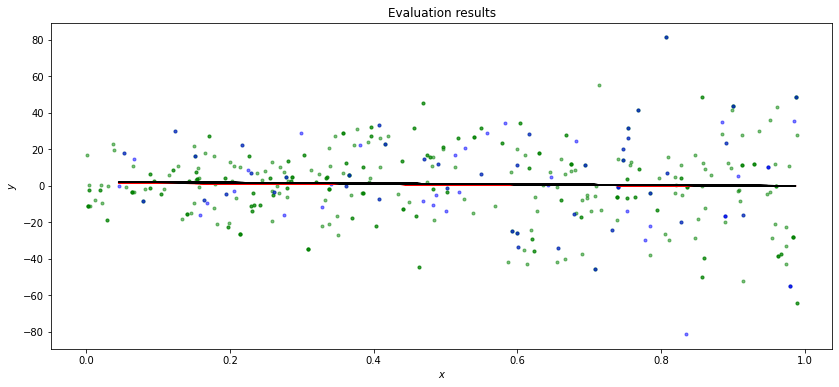

In [28]:
plt.figure(figsize=(14,6))
plt.title("Evaluation results")
plt.plot(x_t, y_t, '.', alpha=0.5, color='green' ) 
plt.plot(xval_t, yval_t, '.', alpha=0.5, color='blue' ) 
plt.plot(xval_t, torch_preds, color='red' ) 
plt.plot(xval_t, syft_preds, color='black' ) 
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.show()

#### Epoch Loss - train and validation  

<AxesSubplot:xlabel='epochs', ylabel='value'>

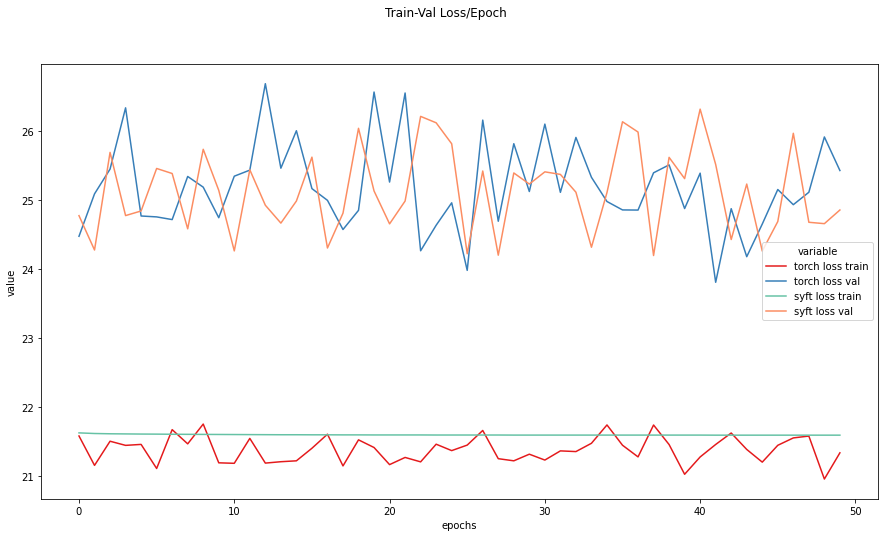

In [29]:
train_val_loss_torch = pd.DataFrame.from_dict(torch_loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_sytt = pd.DataFrame.from_dict(syft_loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs", 'train':'syft loss train', 'val':'syft loss val'})

fig = plt.figure(figsize=(15,8))
fig.suptitle('Train-Val Loss/Epoch')
sns.lineplot(data=train_val_loss_torch, x="epochs", y="value", hue="variable", palette= "Set1")
sns.lineplot(data=train_val_loss_sytt, x="epochs", y="value", hue="variable", palette= "Set2")  

#### Evaluation metrics

In [30]:
mse_t = m.mean_squared_error(xval_t, torch_preds)
r_square_t = m.r2_score(xval_t, torch_preds)

print("PyTorch Mean Squared Error :",mse_t)
print("PyTorch R^2 :",r_square_t)

PyTorch Mean Squared Error : 0.57501113
PyTorch R^2 : -7.047260434758071


In [31]:
mse_s = m.mean_squared_error(xval_t, syft_preds)
r_square_s = m.r2_score(xval_t, syft_preds)

print("PySyft Mean Squared Error :",mse_s)
print("PySyft R^2 :",r_square_s)

PySyft Mean Squared Error : 0.84535426
PySyft R^2 : -10.830702966492252


### PySyft: Understanding the dataset federation and training with FederatedDataLoader

Here, we will try to address the following two questions:
 - *How is the dataset federated between workers?*
 - *How is the learning process executed in federated learning?*

Here, we try to simulate the behaviour in one epoch. We iterate through the FederatedDataLoader to know how the dataset is distributed and the order in which we call workers for training. *Note: remember that we use the worker location to call the model in training, so we train based on the order that we get the location.id from the mini-batch.*

Executing: node1 | batch len: 64 
Executing: node1 | batch len: 61 
Executing: node2 | batch len: 64 
Executing: node2 | batch len: 61 
Executing: node3 | batch len: 64 
Executing: node3 | batch len: 61 


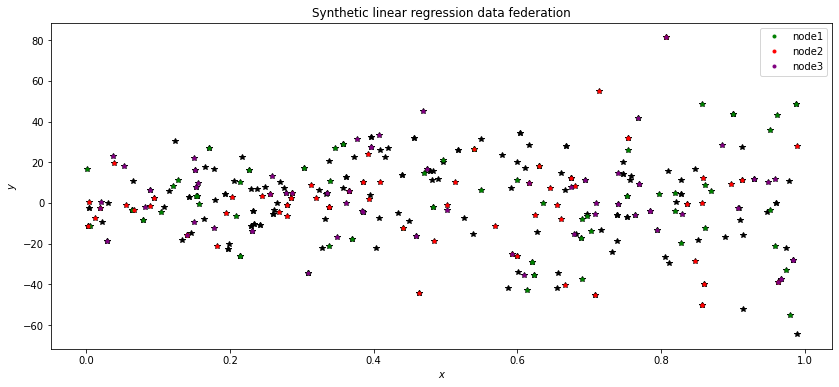

In [14]:
node1 = sy.VirtualWorker(hook, id="node1")
node2 = sy.VirtualWorker(hook, id="node2")
node3 = sy.VirtualWorker(hook, id="node3")

federated_train_loader = sy.FederatedDataLoader(
    ds_train_.federate((node1, node2, node3)), batch_size=64, shuffle=True)

node_data = {"node1":{"x":[], "y":[]}, "node2":{"x":[], "y":[]}, "node3":{"x":[], "y":[]}}

for batch_idx, (xb_train, yb_train) in enumerate(federated_train_loader):
    print('Executing: {} | batch len: {} '.format(str(xb_train.location.id), len(xb_train)))
    node_data[str(xb_train.location.id)]['x'].append(xb_train.get())
    node_data[str(yb_train.location.id)]['y'].append(yb_train.get())

plt.figure(figsize=(14,6))
plt.title("Synthetic linear regression data federation")
plt.plot(x, y, '*', color='black' ) 
node1, = plt.plot(node_data['node1']['x'][0].data, node_data['node1']['y'][0].data, '.', color='green', label="node1") 
node2, = plt.plot(node_data['node2']['x'][0].data, node_data['node2']['y'][0].data, '.', color='red', label="node2") 
node3, = plt.plot(node_data['node3']['x'][0].data, node_data['node3']['y'][0].data, '.', color='purple', label="node3")  
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.legend(handles=[node1, node2, node3])
plt.show()

In [21]:
node1 = sy.VirtualWorker(hook, id="node1")
node2 = sy.VirtualWorker(hook, id="node2")
node3 = sy.VirtualWorker(hook, id="node3")

federated_train_loader = sy.FederatedDataLoader(
    ds_train_.federate((node1, node2, node3)), batch_size=64, iter_per_worker=True,  shuffle=True)

node_data = {"node1":{"x":[], "y":[]}, "node2":{"x":[], "y":[]}, "node3":{"x":[], "y":[]}}
for batch_idx, (xb_train, yb_train) in enumerate(federated_train_loader):
    print('Executing: {} | batch len: {} '.format(str(xb_train.location.id), len(xb_train)))
    node_data[str(xb_train.location.id)]['x'].append(xb_train.get())
    node_data[str(yb_train.location.id)]['y'].append(yb_train.get())

plt.figure(figsize=(14,6))
plt.title("Synthetic linear regression data - training and validation")
plt.plot(x, y, '*', color='black' ) 
plt.plot(node_data['node1']['x'][0].data, node_data['node1']['y'][0].data, '.', color='green', label="node1") 
plt.plot(node_data['node2']['x'][0].data, node_data['node2']['y'][0].data, '.', color='red', label="node2") 
plt.plot(node_data['node3']['x'][0].data, node_data['node3']['y'][0].data, '.', color='purple', label="node3")  
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.show()

ValueError: too many values to unpack (expected 2)

### Conclusions

In [ ]:
TODO:
    * optimizers
    * How gradients are aggregated?

### References

In [ ]:
https://blog.openmined.org/federated-learning-additive-secret-sharing-pysyft/
 Federated Averaging algorithm https://arxiv.org/abs/1602.05629